# bar plots
Example stacked bar plots with Formula 1 data from https://ergast.com/mrd/db

In [1]:
%autosave 0

from etl import DATADIR, ErgastF1
from viz import Plot

f1 = ErgastF1(DATADIR / 'ergast/f1.zip')
plot = Plot()

Autosave disabled


## What % of points went to each team on each year?

In [2]:
share = (

    # Get team points, race dates, and team names since 1990.
    f1.team_results
    .loc[lambda df: df['points'] > 0]
    .join(f1.races['date'], on='id_race')
    .loc[lambda df: df['date'] > '1990']
    .join(f1.teams['team'], on='id_team')
    
    # Count points for each (year, team) since 1990.
    .groupby('date team'.split())
    ['points'].sum().unstack(fill_value=0)
    .resample('y').sum()
    .assign(year = lambda df: df.index.year)
    .set_index('year')
)

# Normalize each year's points.
share = share.mul(100 / share.sum(axis=1), axis=0)

# Focus on a few teams for easier reading.
share = share[share.max().nlargest(12).index]

share.head()

team,Ferrari,Williams,McLaren,Mercedes,Red Bull,Benetton,Renault,Brawn,BMW Sauber,BAR,Lotus F1,Jordan
year,,,,,,,,,,,,
1990,27.500000,14.250000,30.250000,0.0,0.0,17.750000,0.0,0.0,0.0,0.0,0.0,0.000000
1991,13.771712,31.017370,34.491315,0.0,0.0,9.553350,0.0,0.0,0.0,0.0,0.0,3.225806
1992,5.048077,39.423077,23.798077,0.0,0.0,21.875000,0.0,0.0,0.0,0.0,0.0,0.240385
1993,6.730769,40.384615,20.192308,0.0,0.0,17.307692,0.0,0.0,0.0,0.0,0.0,0.721154
1994,17.067308,28.365385,10.096154,0.0,0.0,24.759615,0.0,0.0,0.0,0.0,0.0,6.730769


In [3]:
from collections import defaultdict

color = {
    'BAR': '#77bb77',
    'Benetton': '#00bb00',
    'BMW Sauber': '#bbbbbb',
    'Brawn': '#77ff00',
    'Ferrari': "#ff0000",
    'McLaren': "#ffbb00",
    'Mercedes': '#77ffff',
    'Red Bull': '#330077',
    'Renault': '#00bbff',
    'Williams': '#0000ff',
    'Jordan': '#ffff00'
}
color = defaultdict(lambda: '#000000', color)

## total competition

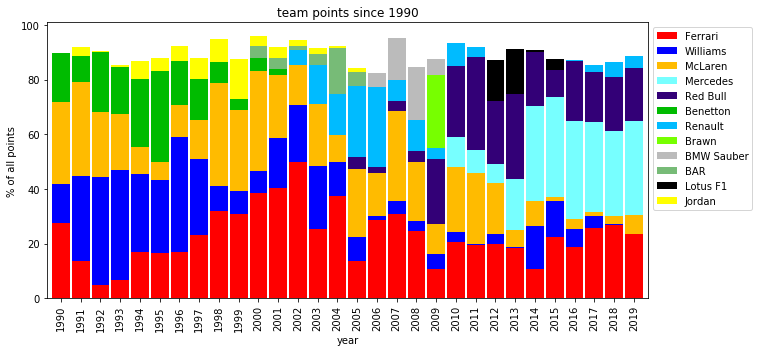

In [4]:
kw = dict()
kw['color'] = share.columns.map(color)
kw['title'] = 'team points since 1990'
kw['ylabel'] = '% of all points'

axes = plot.bar(share, **kw)

## a clockwork red

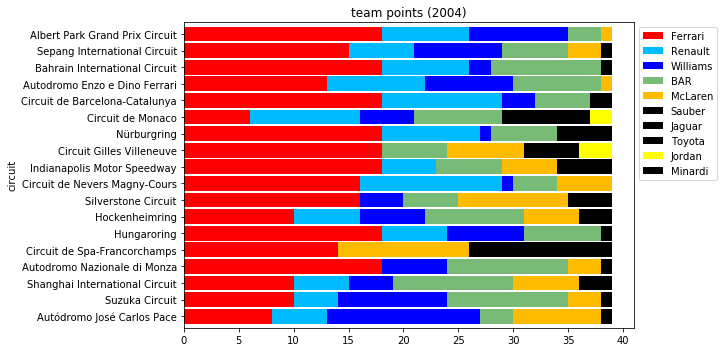

In [5]:
year = 2004
data = (

    # Get points, circuits, and teams for selected year.
    f1.team_results
    .loc[lambda df: df['points'] > 0]
    .join(f1.races['date id_circuit'.split()], on='id_race')
    .set_index('date').loc[str(year)].sort_index()
    .join(f1.teams['team'], on='id_team')
    .join(f1.circuits['circuit'], on='id_circuit')
    
    # Count points for each (circuit, team)
    .groupby(['circuit', 'team'], sort=False)
    ['points'].sum().unstack(fill_value=0)
)
kw = dict()
kw['color'] = data.columns.map(color)
kw['title'] = f"team points ({year})"

axes = plot.barh(data, **kw)

## historical notes

### 1986-1991: Honda Power
- Honda engines powered every 1986-1991 constructors' champion.
- McLaren-Honda won every 1988-1991 constructors' championship from 1988-1991.
- Senna won every 1988-1991 drivers' championship except 1989 (Prost).
- Prost left McLaren in 1990. Honda left F1 in 1993.

### 1992-2004: Schuey vs. Newey
- In 1991, Michael Schumacher joined Benetton and Adrian Newey joined Williams.
- Safety rules changed mid-1994 after Senna and Ratzenberger suffered fatal accidents.
- The Michael won every drivers' championship from 1994-2004 except 1996 (Hill) and 1997 (Villeneuve).
- The Michael moved to Ferrari in 1996. Ross Brawn and several Benetton engineers joined him in 1997.
- Newey joined McLaren-Mercedes in 1997 after one year of "gardening leave."
- Häkkinen won 1998-1999 drivers' championships driving for McLaren-Mercedes.
- Ferrari won half of all points in 2002 and all 2000-2004 constructors' championships.

### 2005-2009:  Challengers Appear
- Ferrari suffered under the "one tire rule" in 2005 except at Indianapolis.
- Alonso won the 2005 and 2006 drivers' championships with Renault, then moved to McLaren-Mercedes.
- McLaren's drivers, champ Alonso and rookie Hamilton, battled in 2007. Räikkonen won in a Ferrari.
- McLaren scored the most points in 2007 but were disqualified due to "Spygate."
- Ferrari won the 2008 constructors championship, but Hamilton won the drivers' in a McLaren-Mercedes.
- Brawn won the 2009 constructors' championship in their first year, then became Mercedes.
- Button won the 2009 drivers' championship, then moved to McLaren.

### 2010-2013: They Gave Seb Wings
- Red Bull hired Newey in 2006 and Vettel (to their "b-team" Toro Rosso) in 2007.
- Vettel and Red Bull won all 2010-2013 drivers' and constructors' championships.

### 2014-???: Hammer Time
- Mercedes won every constructor's championship of the "turbo hybrid era" since 2014.
- Hamilton won every drivers' championship since 2014 except 2016 (Rosberg).